<a href="https://colab.research.google.com/github/datacommonsorg/api-python/blob/master/Case_Study_Analyzing_Income_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC.
SPDX-License-Identifier: Apache-2.0

**Notebook Version** - 1.0.1

In [1]:
# Install datacommons
!pip install datacommons_pandas --upgrade --quiet

# Analyzing Income Distribution

The American Community Survey (published by the US Census) annually reports the number of individuals in a given income bracket at the state level. We can use this information, stored in Data Commons, to visualize disparity in income for each state in the US. Our goal for this tutorial will be to generate a plot that visualizes the total number of individuals across a given set of income brackets for a given state. 

Before we begin, we'll setup our notebook.

In [2]:
# Import the Data Commons Pandas library
import datacommons_pandas as dc

# Import other libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


## Getting the Data

The Data Commons graph identifies 16 different income brackets. The list of these variable can be found under the "Household" category in our [list of StatisticalVariables](http://docs.datacommons.org/statistical_variables.html).


We can use **`get_places_in`** to get all states within the United States. We can then call **`build_multivariate_dataframe`** on the list of states to get a dataframe per-income bracket population counts for each state.


In [3]:
states = dc.get_places_in(['country/USA'], 'State')['country/USA']

In [4]:
# A list of income bracket StatisticalVariables
income_brackets = [
                   "Count_Household_IncomeOfUpto10000USDollar",
                   "Count_Household_IncomeOf10000To14999USDollar",
                   "Count_Household_IncomeOf15000To19999USDollar",
                   "Count_Household_IncomeOf20000To24999USDollar",
                   "Count_Household_IncomeOf25000To29999USDollar",
                   "Count_Household_IncomeOf30000To34999USDollar",
                   "Count_Household_IncomeOf35000To39999USDollar",
                   "Count_Household_IncomeOf40000To44999USDollar",
                   "Count_Household_IncomeOf45000To49999USDollar",
                   "Count_Household_IncomeOf50000To59999USDollar",
                   "Count_Household_IncomeOf60000To74999USDollar",
                   "Count_Household_IncomeOf75000To99999USDollar",
                   "Count_Household_IncomeOf100000To124999USDollar",
                   "Count_Household_IncomeOf125000To149999USDollar",
                   "Count_Household_IncomeOf150000To199999USDollar",
                   "Count_Household_IncomeOf200000OrMoreUSDollar",
]

data = dc.build_multivariate_dataframe(states, income_brackets)
data.head()

,Count_Household_IncomeOf25000To29999USDollar,Count_Household_IncomeOf75000To99999USDollar,Count_Household_IncomeOf40000To44999USDollar,Count_Household_IncomeOf100000To124999USDollar,Count_Household_IncomeOf125000To149999USDollar,Count_Household_IncomeOfUpto10000USDollar,Count_Household_IncomeOf15000To19999USDollar,Count_Household_IncomeOf35000To39999USDollar,Count_Household_IncomeOf200000OrMoreUSDollar,Count_Household_IncomeOf30000To34999USDollar,Count_Household_IncomeOf60000To74999USDollar,Count_Household_IncomeOf150000To199999USDollar,Count_Household_IncomeOf50000To59999USDollar,Count_Household_IncomeOf10000To14999USDollar,Count_Household_IncomeOf20000To24999USDollar,Count_Household_IncomeOf45000To49999USDollar
place,,,,,,,,,,,,,,,,
geoId/01,100244,213319,86970,139638,82409,163312,114088,89216,69504,98408,176464,78452,147857,117629,108736,74023
geoId/02,8830,36073,9759,29553,20043,10230,7962,8630,20134,8897,27311,23692,18000,7609,8567,8172
geoId/04,125448,315900,123277,211274,131233,170434,118026,118929,133692,125317,262334,133172,210570,111075,126194,107425
geoId/05,69556,124254,60069,78338,44816,93423,70617,61375,37690,65675,111457,39928,95124,74534,73576,51743
geoId/06,510114,1589511,495884,1225091,877148,656515,499894,480115,1421052,513108,1184505,1082448,880868,573531,536077,439574


To get the names of states, we can use the `get_property_values` function:

In [5]:
# Get all state names and store it in a column "name"
# Get the first name, if there are multiple for a state
data.insert(0, 'name', data.index.map(dc.get_property_values(data.index, 'name')).str[0])

data.head(5)

,name,Count_Household_IncomeOf25000To29999USDollar,Count_Household_IncomeOf75000To99999USDollar,Count_Household_IncomeOf40000To44999USDollar,Count_Household_IncomeOf100000To124999USDollar,Count_Household_IncomeOf125000To149999USDollar,Count_Household_IncomeOfUpto10000USDollar,Count_Household_IncomeOf15000To19999USDollar,Count_Household_IncomeOf35000To39999USDollar,Count_Household_IncomeOf200000OrMoreUSDollar,Count_Household_IncomeOf30000To34999USDollar,Count_Household_IncomeOf60000To74999USDollar,Count_Household_IncomeOf150000To199999USDollar,Count_Household_IncomeOf50000To59999USDollar,Count_Household_IncomeOf10000To14999USDollar,Count_Household_IncomeOf20000To24999USDollar,Count_Household_IncomeOf45000To49999USDollar
place,,,,,,,,,,,,,,,,,
geoId/01,Alabama,100244,213319,86970,139638,82409,163312,114088,89216,69504,98408,176464,78452,147857,117629,108736,74023
geoId/02,Alaska,8830,36073,9759,29553,20043,10230,7962,8630,20134,8897,27311,23692,18000,7609,8567,8172
geoId/04,Arizona,125448,315900,123277,211274,131233,170434,118026,118929,133692,125317,262334,133172,210570,111075,126194,107425
geoId/05,Arkansas,69556,124254,60069,78338,44816,93423,70617,61375,37690,65675,111457,39928,95124,74534,73576,51743
geoId/06,California,510114,1589511,495884,1225091,877148,656515,499894,480115,1421052,513108,1184505,1082448,880868,573531,536077,439574


## Analyzing the Data

Let's plot our data as a histogram. **Notice that the income ranges as tabulated by the US Census are not equal.** At the low end, the range is 0-9999, whereas, towards the top, the range 150,000-199,999 is five times as broad! **We will make the width of each of the columns correspond to their range, and will give us an idea of the total earnings, not just the number of people in that group.**

First we provide code for generating the plot.

In [6]:
# Bar chart endpoints (for calculating bar width)
label_to_range = {
  "Count_Household_IncomeOfUpto10000USDollar": [0, 9999],
  "Count_Household_IncomeOf10000To14999USDollar": [10000, 14999],
  "Count_Household_IncomeOf15000To19999USDollar": [15000, 19999],
  "Count_Household_IncomeOf20000To24999USDollar": [20000, 24999],
  "Count_Household_IncomeOf25000To29999USDollar": [25000, 29999],
  "Count_Household_IncomeOf30000To34999USDollar": [30000, 34999],
  "Count_Household_IncomeOf35000To39999USDollar": [35000, 39999],
  "Count_Household_IncomeOf40000To44999USDollar": [40000, 44999],
  "Count_Household_IncomeOf45000To49999USDollar": [45000, 49999],
  "Count_Household_IncomeOf50000To59999USDollar": [50000, 59999],
  "Count_Household_IncomeOf60000To74999USDollar": [60000, 74999],
  "Count_Household_IncomeOf75000To99999USDollar": [75000, 99999],
  "Count_Household_IncomeOf100000To124999USDollar": [100000, 124999],
  "Count_Household_IncomeOf125000To149999USDollar": [125000, 149999],
  "Count_Household_IncomeOf150000To199999USDollar": [150000, 199999],
  "Count_Household_IncomeOf200000OrMoreUSDollar": [200000, 300000],
}

def plot_income(data, state_name):
  # Assert that specified "state_name" is a valid state name
  frame_search = data.loc[data['name'] == state_name].squeeze()
  if frame_search.shape[0] == 0:
    print('{} does not have sufficient income data to generate the plot!'.format(state_name))
    return
  
  # Print the resulting series
  data = frame_search[1:]

  # Calculate the lengths without intervals
  widths_without_interval = []
  for bracket in income_brackets:
    r = label_to_range[bracket] 
    widths_without_interval.append(int((r[1] - r[0]) / 18))

  # Calculate the x-axis positions
  pos, total = [], 0
  for l in widths_without_interval:
    pos.append(total + (l // 2))
    total += l

  # Calculate the bar lengths
  widths = []
  for bracket in income_brackets:
    r = label_to_range[bracket] 
    # 50 here to be the intervals between bars
    widths.append(int((r[1] - r[0]) / 18 - 50))

  # Plot the histogram
  plt.figure(figsize=(12, 10))
  plt.xticks(pos, income_brackets, rotation=90)
  plt.grid(True)
  plt.bar(pos, data.values, widths, color='b', alpha=0.3)

  # Return the resulting frame.
  return frame_search

We can then call this code with a state to plot the income bracket sizes.

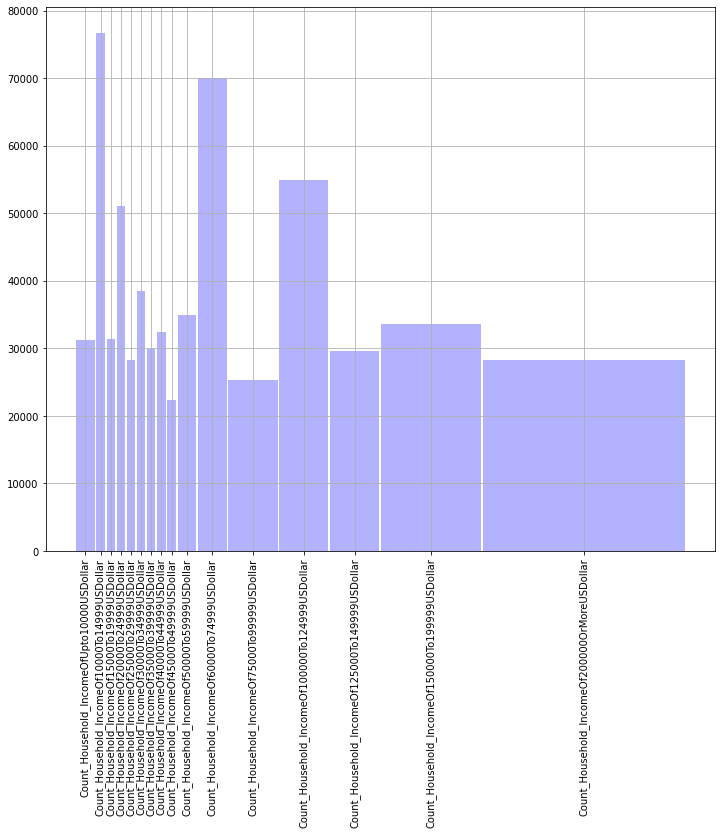

In [7]:
#@title Enter State to plot { run: "auto" }
state_name = "Idaho" #@param ["Missouri", "Arkansas", "Arizona", "Ohio", "Connecticut", "Vermont", "Illinois", "South Dakota", "Iowa", "Oklahoma", "Kansas", "Washington", "Oregon", "Hawaii", "Minnesota", "Idaho", "Alaska", "Colorado", "Delaware", "Alabama", "North Dakota", "Michigan", "California", "Indiana", "Kentucky", "Nebraska", "Louisiana", "New Jersey", "Rhode Island", "Utah", "Nevada", "South Carolina", "Wisconsin", "New York", "North Carolina", "New Hampshire", "Georgia", "Pennsylvania", "West Virginia", "Maine", "Mississippi", "Montana", "Tennessee", "New Mexico", "Massachusetts", "Wyoming", "Maryland", "Florida", "Texas", "Virginia"]
result = plot_income(data, state_name)

# Show the plot
plt.show()

and we can display the raw table of values.

In [8]:
# Additionally print the table of income bracket sizes 
result

name                                              Idaho
Count_Household_IncomeOf25000To29999USDollar      31268
Count_Household_IncomeOf75000To99999USDollar      76641
Count_Household_IncomeOf40000To44999USDollar      31324
Count_Household_IncomeOf100000To124999USDollar    51057
Count_Household_IncomeOf125000To149999USDollar    28311
Count_Household_IncomeOfUpto10000USDollar         38492
Count_Household_IncomeOf15000To19999USDollar      29865
Count_Household_IncomeOf35000To39999USDollar      32391
Count_Household_IncomeOf200000OrMoreUSDollar      22323
Count_Household_IncomeOf30000To34999USDollar      34988
Count_Household_IncomeOf60000To74999USDollar      70028
Count_Household_IncomeOf150000To199999USDollar    25253
Count_Household_IncomeOf50000To59999USDollar      54943
Count_Household_IncomeOf10000To14999USDollar      29568
Count_Household_IncomeOf20000To24999USDollar      33635
Count_Household_IncomeOf45000To49999USDollar      28244
Name: geoId/16, dtype: object

This is only the beginning! What else can you analyze? For example, you could try computing a measure of income disparity in each state (see [Gini Coefficient](https://en.wikipedia.org/wiki/Gini_coefficient)).

You could then expand the dataframe to include more information and analyze how attributes like education level, crime, or even weather affect income disparity.

